In [62]:
#reference: https://www.kaggle.com/benjibb/lstm-stock-prediction-20170507?scriptVersionId=1139231
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
from keras.layers import Input
from keras.models import Model
import keras
import h5py
import requests
import os

In [63]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
    return df

# function for build the training data and test data
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
#     print(result.shape)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
#     print(x_train.shape)
#     print(y_train.shape)
    
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]
#     print(x_test.shape)
#     print(y_test.shape)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [64]:
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df.head()

,symbol,open,low,high,volume,adj close
date,,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,2163600.0,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,2386400.0,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,2489500.0,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,2006300.0,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,1408600.0,114.970001


In [65]:
# df = normalize_data(df)
# df.head()


In [66]:
symbols = list(set(df.symbol))
# print (symbols)

In [67]:
science_list = ['GOOG','AAPL','YHOO','AMZN']
encoding_dim = 10 
# for symbol in science_list:
#     thisdf = df[df.symbol == symbol]
#     input_img = Input(shape=(22,))
#     encoded = Dense(encoding_dim, activation='relu')(input_img)
#     decoded = Dense(784, activation='sigmoid')(encoded)
#     autoencoder = Model(input_img, decoded)
#     encoder = Model(input_img, encoded)
stock_interest = 'AAPL'
df3 = df[df.symbol == stock_interest]
df3.drop(['symbol'],1,inplace=True)
df3.head()

/Users/sophiawj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,open,low,high,volume,adj close
date,,,,,
2010-01-04,30.490000,30.340000,30.642857,123432400.0,30.572857
2010-01-05,30.657143,30.464285,30.798571,150476200.0,30.625713
2010-01-06,30.625713,30.107143,30.747143,138040000.0,30.138571
2010-01-07,30.250000,29.864286,30.285715,119282800.0,30.082857
2010-01-08,30.042856,29.865715,30.285715,111902700.0,30.282858


In [68]:
window = 22
X_train, y_train, X_test, y_test = load_data(df3, window)
print (X_train.shape)

(1565, 22, 5)


In [69]:
print (X_train.shape)
X_train = X_train.reshape(1565,22*5)


(1565, 22, 5)


In [70]:
print (X_test.shape)
X_test = X_test.reshape(174,22*5)

(174, 22, 5)


In [71]:
#Test the performance of autoencoder on the time series
# build the model
input_img = Input(shape=(22*5,))
encoding_dim = 10 
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(22*5, activation='linear')(encoded)
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [72]:
print (X_train)
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
autoencoder.fit(X_train, X_train,
                epochs=150,
                batch_size=256,
                callbacks=[earlyStopping],
                shuffle=True,
                validation_data=(X_test, X_test))

[[  3.04899997e+01   3.03400001e+01   3.06428566e+01 ...,   2.86000004e+01
    1.53832000e+08   2.84614277e+01]
 [  3.06571426e+01   3.04642849e+01   3.07985706e+01 ...,   2.83385716e+01
    1.89413000e+08   2.74357147e+01]
 [  3.06257133e+01   3.01071434e+01   3.07471429e+01 ...,   2.80000000e+01
    2.12576700e+08   2.79228573e+01]
 ..., 
 [  1.06339996e+02   1.05190002e+02   1.06500000e+02 ...,   1.08000000e+02
    3.23849000e+07   1.06910004e+02]
 [  1.05930000e+02   1.05139999e+02   1.07650002e+02 ...,   1.08089996e+02
    3.06110000e+07   1.07129997e+02]
 [  1.05250000e+02   1.05209999e+02   1.07290001e+02 ...,   1.06930000e+02
    3.15525000e+07   1.05970001e+02]]
Train on 1565 samples, validate on 174 samples
Epoch 1/150
1565/1565 [==============================] - 1s 552us/step - loss: 2801091116225682.0000 - val_loss: 325182778507264.0000
Epoch 2/150
1565/1565 [==============================] - 0s 16us/step - loss: 2757366656036500.0000 - val_loss: 320080793567232.0000
Epoch 

1565/1565 [==============================] - 0s 13us/step - loss: 277331177812556.8750 - val_loss: 41645361856512.0000
Epoch 58/150
1565/1565 [==============================] - 0s 15us/step - loss: 276180144855282.0938 - val_loss: 41392311107584.0000
Epoch 59/150
1565/1565 [==============================] - 0s 16us/step - loss: 274161037859089.5000 - val_loss: 41229819576320.0000
Epoch 60/150
1565/1565 [==============================] - 0s 15us/step - loss: 273185495277992.0000 - val_loss: 41066698899456.0000
Epoch 61/150
1565/1565 [==============================] - 0s 18us/step - loss: 271981137360096.4375 - val_loss: 40978815647744.0000
Epoch 62/150
1565/1565 [==============================] - 0s 12us/step - loss: 271172689771968.1875 - val_loss: 40693930131456.0000
Epoch 63/150
1565/1565 [==============================] - 0s 15us/step - loss: 269438854966691.4062 - val_loss: 40455064518656.0000
Epoch 64/150
1565/1565 [==============================] - 0s 14us/step - loss: 2680320720

1565/1565 [==============================] - 0s 12us/step - loss: 191578365372812.5312 - val_loss: 29862735642624.0000
Epoch 120/150
1565/1565 [==============================] - 0s 14us/step - loss: 202959616716676.9688 - val_loss: 31197239443456.0000
Epoch 121/150
1565/1565 [==============================] - 0s 16us/step - loss: 206307357416409.4062 - val_loss: 28056114692096.0000
Epoch 122/150
1565/1565 [==============================] - 0s 16us/step - loss: 191177368721807.1250 - val_loss: 27940804886528.0000
Epoch 123/150
1565/1565 [==============================] - 0s 14us/step - loss: 192539519749146.8125 - val_loss: 28588126502912.0000
Epoch 124/150
1565/1565 [==============================] - 0s 17us/step - loss: 197575445124796.7812 - val_loss: 30977548091392.0000
Epoch 125/150
1565/1565 [==============================] - 0s 27us/step - loss: 265407166539471.0938 - val_loss: 98194713214976.0000
Epoch 126/150
1565/1565 [==============================] - 0s 24us/step - loss: 601

In [73]:
# thisx = X_test
print (X_test.shape)
thisx = np.array([X_test[1,:]])
print (thisx.shape)
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(encoded_imgs.shape)
print(decoded_imgs.shape)

(174, 110)
(1, 110)
(174, 10)
(174, 110)


In [74]:

# print (thisx)
# print (decoded_imgs[0])


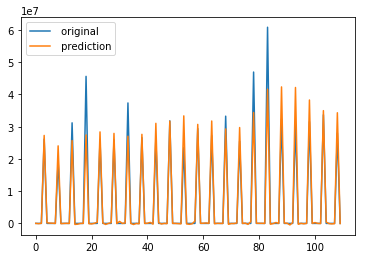

In [75]:
plt.plot(thisx[0],label = ' original')
plt.plot(decoded_imgs[0],label = ' prediction')
plt.legend()
plt.show()

In [76]:
#TODO
# science_list = ['GOOG','AAPL','YHOO','AMZN']
# science_list = ['GOOG','AAPL','YHOO','AMZN', 'MSFT', 'IBM', 'GOOGL', 'FB']
science_list = ['GOOG','AAPL','YHOO','AMZN', 'MSFT', 'IBM', 'GOOGL', 'FB', 'EBAY', 'NVDA', 'ORCL', 'INTC']
encoder_list = []
decoder_list = []
window = 22
for symbol in science_list:
    # prepare the data
    df3 = df[df.symbol == symbol]
    df3.drop(['symbol'],1,inplace=True)
    df3 = normalize_data(df3)
    df3.head()
    X_train, y_train, X_test, y_test = load_data(df3, window)
    X_train = X_train.reshape(X_train.shape[0],22*5)
    X_test = X_test.reshape(X_test.shape[0],22*5)
    
    
    
    # train an autoencoder 
    input_img = Input(shape=(22*5,))
    encoding_dim = 10 
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    decoded = Dense(22*5, activation='linear')(encoded)
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
    earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
    autoencoder.fit(X_train, X_train,
                epochs=150,
                batch_size=256,
                callbacks=[earlyStopping],
                shuffle=True,
                validation_data=(X_test, X_test))
    
#     autoencoder_list.append(None) # append the trained autoencoder
    encoder_list.append(encoder)
    decoder_list.append(decoder)

    
# generate the predicted values for all stocks and put them in one matrix
# train a LSTM using those values
# test the results


/Users/sophiawj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sophiawj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sophiawj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Train on 1565 samples, validate on 174 samples
Epoch 1/150
1565/1565 [==============================] - 1s 435us/step - loss: 0.1682 - val_loss: 0.6747
Epoch 2/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.1554 - val_loss: 0.6342
Epoch 3/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.1470 - val_loss: 0.6024
Epoch 4/150
1565/1565 [==============================] - 0s 18us/step - loss: 0.1394 - val_loss: 0.5724
Epoch 5/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.1316 - val_loss: 0.5346
Epoch 6/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.1216 - val_loss: 0.4860
Epoch 7/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.1089 - val_loss: 0.4259
Epoch 8/150
1565/1565 [==============================] - 0s 18us/step - loss: 0.0937 - val_loss: 0.3512
Epoch 9/150
1565/1565 [==============================] - 0s 19us/step - loss: 0.0758 - val_loss: 0.2727
Epoch 10/150
156

1565/1565 [==============================] - 0s 14us/step - loss: 0.0021 - val_loss: 8.1747e-04
Epoch 79/150
1565/1565 [==============================] - 0s 18us/step - loss: 0.0021 - val_loss: 8.1446e-04
Epoch 80/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0021 - val_loss: 8.2120e-04
Epoch 81/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0021 - val_loss: 8.2255e-04
Epoch 82/150
1565/1565 [==============================] - 0s 19us/step - loss: 0.0020 - val_loss: 8.0914e-04
Epoch 83/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0020 - val_loss: 8.0637e-04
Epoch 84/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0020 - val_loss: 8.2999e-04
Epoch 85/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0020 - val_loss: 8.0546e-04
Epoch 86/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0020 - val_loss: 8.0568e-04
Epoch 87/150
1565/1565 [========

1565/1565 [==============================] - 0s 15us/step - loss: 0.0044 - val_loss: 0.0029
Epoch 48/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0043 - val_loss: 0.0029
Epoch 49/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0043 - val_loss: 0.0028
Epoch 50/150
1565/1565 [==============================] - 0s 13us/step - loss: 0.0042 - val_loss: 0.0027
Epoch 51/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0041 - val_loss: 0.0028
Epoch 52/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0040 - val_loss: 0.0028
Epoch 53/150
1565/1565 [==============================] - ETA: 0s - loss: 0.003 - 0s 14us/step - loss: 0.0040 - val_loss: 0.0026
Epoch 54/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.0039 - val_loss: 0.0026
Epoch 55/150
1565/1565 [==============================] - 0s 18us/step - loss: 0.0039 - val_loss: 0.0026
Epoch 56/150
1565/1565 [====================

1565/1565 [==============================] - 0s 16us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 125/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 126/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 127/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 128/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 129/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 130/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 131/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 132/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 133/150
1565/1565 [==============================] - 0

1565/1565 [==============================] - 0s 15us/step - loss: 0.0014 - val_loss: 8.1884e-04
Epoch 51/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 8.1002e-04
Epoch 52/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0014 - val_loss: 8.6315e-04
Epoch 53/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0014 - val_loss: 8.4303e-04
Epoch 54/150
1565/1565 [==============================] - 0s 18us/step - loss: 0.0014 - val_loss: 8.4317e-04
Epoch 55/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0014 - val_loss: 8.0695e-04
Epoch 56/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 8.2659e-04
Epoch 57/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 7.9406e-04
Epoch 58/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 7.9907e-04
Epoch 59/150
1565/1565 [========

Epoch 4/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0731 - val_loss: 0.5593
Epoch 5/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0689 - val_loss: 0.5293
Epoch 6/150
1565/1565 [==============================] - 0s 18us/step - loss: 0.0643 - val_loss: 0.4971
Epoch 7/150
1565/1565 [==============================] - 0s 18us/step - loss: 0.0594 - val_loss: 0.4578
Epoch 8/150
1565/1565 [==============================] - 0s 19us/step - loss: 0.0537 - val_loss: 0.4082
Epoch 9/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0470 - val_loss: 0.3568
Epoch 10/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.0403 - val_loss: 0.2985
Epoch 11/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0331 - val_loss: 0.2412
Epoch 12/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0264 - val_loss: 0.1905
Epoch 13/150
1565/1565 [==============================] - 0s 

1565/1565 [==============================] - 0s 15us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 83/150
1565/1565 [==============================] - 0s 13us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 84/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 85/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 86/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 87/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 88/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 89/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 90/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 91/150
1565/1565 [==============================] - 0s 18us/st

Epoch 62/150
1565/1565 [==============================] - 0s 18us/step - loss: 0.0018 - val_loss: 0.0015
Epoch 63/150
1565/1565 [==============================] - 0s 23us/step - loss: 0.0018 - val_loss: 0.0015
Epoch 64/150
1565/1565 [==============================] - 0s 21us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 65/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 66/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 67/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 68/150
1565/1565 [==============================] - 0s 19us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 69/150
1565/1565 [==============================] - 0s 18us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 70/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 71/150
1565/1565 [==============================]

1565/1565 [==============================] - 0s 13us/step - loss: 0.0458 - val_loss: 0.0133
Epoch 13/150
1565/1565 [==============================] - 0s 12us/step - loss: 0.0315 - val_loss: 0.0091
Epoch 14/150
1565/1565 [==============================] - 0s 13us/step - loss: 0.0218 - val_loss: 0.0064
Epoch 15/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0156 - val_loss: 0.0047
Epoch 16/150
1565/1565 [==============================] - 0s 13us/step - loss: 0.0117 - val_loss: 0.0036
Epoch 17/150
1565/1565 [==============================] - 0s 13us/step - loss: 0.0092 - val_loss: 0.0030
Epoch 18/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0077 - val_loss: 0.0026
Epoch 19/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0068 - val_loss: 0.0024
Epoch 20/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0062 - val_loss: 0.0023
Epoch 21/150
1565/1565 [==============================] - 0s 14us/st

Epoch 20/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0042 - val_loss: 0.0043
Epoch 21/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0040 - val_loss: 0.0038
Epoch 22/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0039 - val_loss: 0.0033
Epoch 23/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0038 - val_loss: 0.0029
Epoch 24/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.0037 - val_loss: 0.0027
Epoch 25/150
1565/1565 [==============================] - 0s 21us/step - loss: 0.0036 - val_loss: 0.0025
Epoch 26/150
1565/1565 [==============================] - 0s 18us/step - loss: 0.0035 - val_loss: 0.0025
Epoch 27/150
1565/1565 [==============================] - 0s 21us/step - loss: 0.0035 - val_loss: 0.0024
Epoch 28/150
1565/1565 [==============================] - 0s 20us/step - loss: 0.0034 - val_loss: 0.0022
Epoch 29/150
1565/1565 [==============================]

Epoch 97/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0019 - val_loss: 9.0635e-04
Epoch 98/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.0019 - val_loss: 9.1880e-04
Epoch 99/150
1565/1565 [==============================] - 0s 13us/step - loss: 0.0019 - val_loss: 9.2078e-04
Epoch 100/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0019 - val_loss: 8.9502e-04
Epoch 101/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.0019 - val_loss: 8.9435e-04
Epoch 102/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0019 - val_loss: 9.5306e-04
Epoch 103/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0019 - val_loss: 9.1298e-04
Epoch 104/150
1565/1565 [==============================] - 0s 18us/step - loss: 0.0019 - val_loss: 9.2299e-04
Epoch 105/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0019 - val_loss: 8.9366e-04
Epoch 106/150

Epoch 64/150
886/886 [==============================] - 0s 17us/step - loss: 0.0023 - val_loss: 0.0017
Epoch 65/150
886/886 [==============================] - 0s 18us/step - loss: 0.0023 - val_loss: 0.0017
Epoch 66/150
886/886 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0016
Epoch 67/150
886/886 [==============================] - 0s 21us/step - loss: 0.0022 - val_loss: 0.0016
Epoch 68/150
886/886 [==============================] - 0s 18us/step - loss: 0.0022 - val_loss: 0.0016
Epoch 69/150
886/886 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 0.0016
Epoch 70/150
886/886 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 0.0016
Epoch 71/150
886/886 [==============================] - 0s 20us/step - loss: 0.0022 - val_loss: 0.0016
Epoch 72/150
886/886 [==============================] - 0s 19us/step - loss: 0.0022 - val_loss: 0.0016
Epoch 73/150
886/886 [==============================] - 0s 16us/step - lo

886/886 [==============================] - 0s 16us/step - loss: 0.0017 - val_loss: 9.0869e-04
Epoch 143/150
886/886 [==============================] - 0s 21us/step - loss: 0.0017 - val_loss: 9.0099e-04
Epoch 144/150
886/886 [==============================] - 0s 18us/step - loss: 0.0017 - val_loss: 9.0098e-04
Epoch 145/150
886/886 [==============================] - 0s 16us/step - loss: 0.0017 - val_loss: 8.7361e-04
Epoch 146/150
886/886 [==============================] - 0s 15us/step - loss: 0.0017 - val_loss: 8.8763e-04
Epoch 147/150
886/886 [==============================] - 0s 15us/step - loss: 0.0017 - val_loss: 8.7583e-04
Epoch 148/150
886/886 [==============================] - 0s 20us/step - loss: 0.0017 - val_loss: 8.6239e-04
Epoch 149/150
886/886 [==============================] - 0s 16us/step - loss: 0.0017 - val_loss: 8.5373e-04
Epoch 150/150
886/886 [==============================] - 0s 25us/step - loss: 0.0017 - val_loss: 8.6896e-04
Train on 1565 samples, validate on 174 sam

1565/1565 [==============================] - 0s 13us/step - loss: 0.0022 - val_loss: 0.0031
Epoch 70/150
1565/1565 [==============================] - 0s 13us/step - loss: 0.0022 - val_loss: 0.0030
Epoch 71/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0022 - val_loss: 0.0031
Epoch 72/150
1565/1565 [==============================] - 0s 13us/step - loss: 0.0022 - val_loss: 0.0030
Epoch 73/150
1565/1565 [==============================] - 0s 13us/step - loss: 0.0021 - val_loss: 0.0030
Epoch 74/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 0.0029
Epoch 75/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0021 - val_loss: 0.0029
Epoch 76/150
1565/1565 [==============================] - 0s 12us/step - loss: 0.0021 - val_loss: 0.0029
Epoch 77/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0021 - val_loss: 0.0028
Epoch 78/150
1565/1565 [==============================] - 0s 14us/st

1565/1565 [==============================] - 0s 16us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 147/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 148/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 149/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 150/150
1565/1565 [==============================] - 0s 18us/step - loss: 0.0018 - val_loss: 0.0021
Train on 1565 samples, validate on 174 samples
Epoch 1/150
1565/1565 [==============================] - 1s 542us/step - loss: 0.0131 - val_loss: 0.1946
Epoch 2/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0123 - val_loss: 0.1885
Epoch 3/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0116 - val_loss: 0.1838
Epoch 4/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0110 - val_loss: 0.1797
Epoch 5/150
1565/156

1565/1565 [==============================] - 0s 17us/step - loss: 0.0035 - val_loss: 0.0982
Epoch 74/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0035 - val_loss: 0.0977
Epoch 75/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0034 - val_loss: 0.0972
Epoch 76/150
1565/1565 [==============================] - 0s 13us/step - loss: 0.0034 - val_loss: 0.0966
Epoch 77/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0034 - val_loss: 0.0958
Epoch 78/150
1565/1565 [==============================] - 0s 13us/step - loss: 0.0034 - val_loss: 0.0954
Epoch 79/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0034 - val_loss: 0.0948
Epoch 80/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0034 - val_loss: 0.0941
Epoch 81/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.0034 - val_loss: 0.0936
Epoch 82/150
1565/1565 [==============================] - 0s 17us/st

1565/1565 [==============================] - 0s 14us/step - loss: 0.0024 - val_loss: 0.0485
Train on 1565 samples, validate on 174 samples
Epoch 1/150
1565/1565 [==============================] - 1s 744us/step - loss: 0.2550 - val_loss: 0.4463
Epoch 2/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.2409 - val_loss: 0.4235
Epoch 3/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.2273 - val_loss: 0.3929
Epoch 4/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.2069 - val_loss: 0.3409
Epoch 5/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.1734 - val_loss: 0.2658
Epoch 6/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.1294 - val_loss: 0.1806
Epoch 7/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0840 - val_loss: 0.1043
Epoch 8/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0474 - val_loss: 0.0526
Epoch 9/150
1565/1565 [=====

Epoch 78/150
1565/1565 [==============================] - 0s 19us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 79/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 80/150
1565/1565 [==============================] - 0s 18us/step - loss: 0.0023 - val_loss: 9.9285e-04
Epoch 81/150
1565/1565 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 9.9598e-04
Epoch 82/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 83/150
1565/1565 [==============================] - 0s 13us/step - loss: 0.0023 - val_loss: 9.7643e-04
Epoch 84/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 85/150
1565/1565 [==============================] - 0s 13us/step - loss: 0.0023 - val_loss: 9.6477e-04
Epoch 86/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.0023 - val_loss: 9.8562e-04
Epoch 87/150
1565/1565 [===========

1565/1565 [==============================] - 0s 13us/step - loss: 0.1875 - val_loss: 0.5049
Epoch 3/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.1709 - val_loss: 0.4655
Epoch 4/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.1563 - val_loss: 0.4256
Epoch 5/150
1565/1565 [==============================] - 0s 20us/step - loss: 0.1410 - val_loss: 0.3747
Epoch 6/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.1223 - val_loss: 0.3163
Epoch 7/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.1016 - val_loss: 0.2551
Epoch 8/150
1565/1565 [==============================] - 0s 18us/step - loss: 0.0809 - val_loss: 0.1944
Epoch 9/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.0614 - val_loss: 0.1398
Epoch 10/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0448 - val_loss: 0.0970
Epoch 11/150
1565/1565 [==============================] - 0s 19us/step - lo

Epoch 80/150
1565/1565 [==============================] - 0s 21us/step - loss: 0.0043 - val_loss: 0.0026
Epoch 81/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.0042 - val_loss: 0.0026
Epoch 82/150
1565/1565 [==============================] - ETA: 0s - loss: 0.003 - 0s 17us/step - loss: 0.0042 - val_loss: 0.0026
Epoch 83/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.0042 - val_loss: 0.0026
Epoch 84/150
1565/1565 [==============================] - 0s 17us/step - loss: 0.0042 - val_loss: 0.0025
Epoch 85/150
1565/1565 [==============================] - 0s 16us/step - loss: 0.0041 - val_loss: 0.0025
Epoch 86/150
1565/1565 [==============================] - 0s 13us/step - loss: 0.0041 - val_loss: 0.0025
Epoch 87/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0041 - val_loss: 0.0024
Epoch 88/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0040 - val_loss: 0.0024
Epoch 89/150
1565/1565 [=======

In [77]:
# train the main model
# for stock in list
# get the data and transform the data
#  bulid the train data
# put into keras

print (encoded_imgs[4])

[  1.79582384e+08   0.00000000e+00   7.76932960e+07   6.94843360e+07
   1.10956432e+08   9.41270640e+07   0.00000000e+00   0.00000000e+00
   8.60133680e+07   1.71148440e+07]


In [78]:
def generate_data(df,symbol_list,encoder_list,deoder_list,window,feature_len):
    data = []
    testdata = []
    label = []
    testlabel = []
    num_symbol = len(symbol_list)
    first = 0
    for symbol in symbol_list:
        df3 = df[df.symbol == symbol]
        df3.drop(['symbol'],1,inplace=True)
        df3 = normalize_data(df3)
        X_train, y_train, X_test, y_test = load_data(df3, window)
        
        X_train = X_train.reshape(X_train.shape[0],22*5)
        num_train = X_train.shape[0]
        X_test = X_test.reshape(X_test.shape[0],22*5)
        num_test = X_test.shape[0]

        
        thisdata = np.zeros([num_train,num_symbol * feature_len])
        thistest = np.zeros([num_test,num_symbol * feature_len])
#         print (num_test)
        i = 0
        for encoder in encoder_list:
            
            encoded_imgs = encoder.predict(X_train)
            thisdata[:,i*feature_len:(i+1)*feature_len] = encoded_imgs
            encoded_imgs = encoder.predict(X_test)
            thistest[:,i*feature_len:(i+1)*feature_len] = encoded_imgs
            i += 1
        if first == 0:
            data = thisdata
            first =1
            testdata = thistest
            label = y_train
            testlabel = y_test
#             print (testdata.shape)
        else:
            data = np.append(data,thisdata,axis=0)
            testdata = np.append(testdata,thistest,axis=0)
            label = np.append(label,y_train)
            testlabel = np.append(testlabel,y_test)
#             print (testdata.shape)
    return data,testdata,label,testlabel


def generate_data_decoded(df,symbol_list,encoder_list,deoder_list,window,feature_len):
    data = []
    testdata = []
    label = []
    testlabel = []
    num_symbol = len(symbol_list)
    first = 0
    for symbol in symbol_list:
        df3 = df[df.symbol == symbol]
        df3.drop(['symbol'],1,inplace=True)
        df3 = normalize_data(df3)
        X_train, y_train, X_test, y_test = load_data(df3, window)
        
        X_train = X_train.reshape(X_train.shape[0],22*5)
        num_train = X_train.shape[0]
        X_test = X_test.reshape(X_test.shape[0],22*5)
        num_test = X_test.shape[0]

        
        thisdata = np.zeros([num_train,window,num_symbol * feature_len])
        thistest = np.zeros([num_test,window,num_symbol * feature_len])
#         print (num_test)
        i = 0
        for encoder in encoder_list:
            
            encoded_imgs = encoder.predict(X_train)
            decoded_imgs = decoder.predict(encoded_imgs)
            decoded_imgs = decoded_imgs.reshape(num_train,window,feature_len)
#             print (decoded_imgs.shape)
            
            thisdata[:,:,i*feature_len:(i+1)*feature_len] = decoded_imgs
            encoded_imgs = encoder.predict(X_test)
            decoded_imgs = decoder.predict(encoded_imgs)
            decoded_imgs = decoded_imgs.reshape(num_test,window,feature_len)
            thistest[:,:,i*feature_len:(i+1)*feature_len] = decoded_imgs
            i += 1
        if first == 0:
            data = thisdata
            first =1
            testdata = thistest
            label = y_train
            testlabel = y_test
#             print (testdata.shape)
        else:
            data = np.append(data,thisdata,axis=0)
            testdata = np.append(testdata,thistest,axis=0)
            label = np.append(label,y_train)
            testlabel = np.append(testlabel,y_test)
#             print (testdata.shape)
    return data,testdata,label,testlabel
# xx = generate_data(df,science_list[0:3],encoder_list[0:3],decoder_list[0:3],window,10)
# xx2 = generate_data_decoded(df,science_list[0:3],encoder_list[0:3],decoder_list[0:3],window,5)    

In [ ]:
xx = generate_data(df,science_list[0:3],encoder_list[0:3],decoder_list[0:3],window,10)
xx2 = generate_data_decoded(df,science_list[0:3],encoder_list[0:3],decoder_list[0:3],window,5)  

In [111]:
xx_s8 = generate_data(df,science_list[0:7],encoder_list[0:7],decoder_list[0:7],window,10)
xx2_s8 = generate_data_decoded(df,science_list[0:7],encoder_list[0:7],decoder_list[0:7],window,5)  

/Users/sophiawj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sophiawj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sophiawj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [80]:
xx_s12 = generate_data(df,science_list,encoder_list,decoder_list,window,10)
xx2_s12 = generate_data_decoded(df,science_list,encoder_list,decoder_list,window,5)  

/Users/sophiawj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sophiawj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sophiawj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [81]:
print (np.array(xx).shape)
print (xx[0].shape)
print (xx[1].shape)
print (xx[2].shape)
print (xx[3].shape)
# xx = xx.reshape(1565,10*4)

(4,)
(6260, 40)
(696, 40)
(6260,)
(696,)


In [119]:
def build_model1(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model
def build_model2(layers):
    d = 0.3
    model = Sequential()
    print (layers)
#     model.add(LSTM(256, input_dim=layers[0], return_sequences=True))
#     model.add(Dropout(d))        
#     model.add(LSTM(256, input_dim=layers[0], return_sequences=False))
#     model.add(Dropout(d))
    model.add(Dense(32,input_dim = 40*3, kernel_initializer="uniform",activation='relu')) 
    model.add(Dropout(d))
#     model.add(Dense(32, kernel_initializer="uniform",activation='relu')) 
#     model.add(Dropout(d))
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    # adam = keras.optimizers.Adam(decay=0.2)
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [83]:
model = build_model2([40,1])
model2 = build_model1([20,window,1])

[40, 1]
Compilation Time :  0.032366037368774414
Compilation Time :  0.02390909194946289


In [31]:
# X_train = xx[0].reshape(xx[0].shape[0],)
model.fit(xx[0],xx[2],batch_size=512,epochs=90,validation_split=0.1,verbose=1)
model2.fit(xx2[0],xx2[2],batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Train on 5634 samples, validate on 626 samples
Epoch 1/90
5634/5634 [==============================] - 0s 74us/step - loss: 0.1602 - acc: 7.0998e-04 - val_loss: 0.1038 - val_acc: 0.0000e+00
Epoch 2/90
5634/5634 [==============================] - 0s 7us/step - loss: 0.0564 - acc: 8.8747e-04 - val_loss: 0.0078 - val_acc: 0.0000e+00
Epoch 3/90
5634/5634 [==============================] - 0s 8us/step - loss: 0.0101 - acc: 0.0011 - val_loss: 0.0079 - val_acc: 0.0000e+00
Epoch 4/90
5634/5634 [==============================] - 0s 8us/step - loss: 0.0100 - acc: 0.0011 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 5/90
5634/5634 [==============================] - 0s 8us/step - loss: 0.0070 - acc: 0.0011 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 6/90
5634/5634 [==============================] - 0s 9us/step - loss: 0.0064 - acc: 0.0011 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 7/90
5634/5634 [==============================] - 0s 9us/step - loss: 0.0064 - acc: 0.0011 - val_loss: 0.0019 

5634/5634 [==============================] - 0s 6us/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 60/90
5634/5634 [==============================] - 0s 7us/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 61/90
5634/5634 [==============================] - 0s 6us/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 62/90
5634/5634 [==============================] - 0s 8us/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 63/90
5634/5634 [==============================] - 0s 7us/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 64/90
5634/5634 [==============================] - 0s 7us/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 65/90
5634/5634 [==============================] - 0s 8us/step - loss: 0.0045 - acc: 0.0011 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 66/90
5634/5634 [================

5634/5634 [==============================] - 20s 4ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 28/90
5634/5634 [==============================] - 20s 4ms/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 29/90
5634/5634 [==============================] - 20s 4ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 30/90
5634/5634 [==============================] - 20s 4ms/step - loss: 0.0025 - acc: 0.0011 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 31/90
5634/5634 [==============================] - 20s 4ms/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 32/90
5634/5634 [==============================] - 20s 4ms/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 33/90
5634/5634 [==============================] - 22s 4ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 34/90
5634/5634 [=========

5634/5634 [==============================] - 21s 4ms/step - loss: 0.0014 - acc: 0.0011 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 86/90
5634/5634 [==============================] - 21s 4ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 87/90
5634/5634 [==============================] - 22s 4ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 88/90
5634/5634 [==============================] - 20s 4ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 89/90
5634/5634 [==============================] - 22s 4ms/step - loss: 0.0014 - acc: 0.0011 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 90/90
5634/5634 [==============================] - 21s 4ms/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.0013 - val_acc: 0.0000e+00


In [115]:
predictions = []
data1 = [xx, xx_s8, xx_s12]
# for i in range(3):
i=1
model = build_model2([40*(i+1),1])
model.fit(data1[i][0],data1[i][2],batch_size=512,epochs=90,validation_split=0.1,verbose=1)
predictions.append(model.predict(data1[i][1]))

[80, 1]
Compilation Time :  0.022706031799316406
Train on 10656 samples, validate on 1185 samples
Epoch 1/90
10656/10656 [==============================] - 2s 200us/step - loss: 0.0775 - acc: 7.5075e-04 - val_loss: 0.0100 - val_acc: 8.4388e-04
Epoch 2/90
10656/10656 [==============================] - 0s 8us/step - loss: 0.0129 - acc: 8.4459e-04 - val_loss: 0.0077 - val_acc: 8.4388e-04
Epoch 3/90
10656/10656 [==============================] - 0s 9us/step - loss: 0.0080 - acc: 9.3844e-04 - val_loss: 0.0013 - val_acc: 8.4388e-04
Epoch 4/90
10656/10656 [==============================] - 0s 9us/step - loss: 0.0070 - acc: 9.3844e-04 - val_loss: 0.0014 - val_acc: 8.4388e-04
Epoch 5/90
10656/10656 [==============================] - 0s 10us/step - loss: 0.0066 - acc: 9.3844e-04 - val_loss: 0.0017 - val_acc: 8.4388e-04
Epoch 6/90
10656/10656 [==============================] - 0s 8us/step - loss: 0.0062 - acc: 9.3844e-04 - val_loss: 0.0015 - val_acc: 8.4388e-04
Epoch 7/90
10656/10656 [===========

Epoch 57/90
10656/10656 [==============================] - 0s 8us/step - loss: 0.0034 - acc: 9.3844e-04 - val_loss: 0.0012 - val_acc: 8.4388e-04
Epoch 58/90
10656/10656 [==============================] - 0s 7us/step - loss: 0.0037 - acc: 9.3844e-04 - val_loss: 8.2463e-04 - val_acc: 8.4388e-04
Epoch 59/90
10656/10656 [==============================] - 0s 7us/step - loss: 0.0036 - acc: 9.3844e-04 - val_loss: 7.3970e-04 - val_acc: 8.4388e-04
Epoch 60/90
10656/10656 [==============================] - 0s 7us/step - loss: 0.0034 - acc: 9.3844e-04 - val_loss: 8.2250e-04 - val_acc: 8.4388e-04
Epoch 61/90
10656/10656 [==============================] - 0s 7us/step - loss: 0.0034 - acc: 9.3844e-04 - val_loss: 0.0012 - val_acc: 8.4388e-04
Epoch 62/90
10656/10656 [==============================] - 0s 7us/step - loss: 0.0035 - acc: 9.3844e-04 - val_loss: 6.6997e-04 - val_acc: 8.4388e-04
Epoch 63/90
10656/10656 [==============================] - 0s 7us/step - loss: 0.0034 - acc: 9.3844e-04 - val_loss

In [120]:
i=2
model = build_model2([40*(i+1),1])
model.fit(data1[i][0],data1[i][2],batch_size=512,epochs=90,validation_split=0.1,verbose=1)
predictions.append(model.predict(data1[i][1]))

[120, 1]
Compilation Time :  0.026886940002441406
Train on 16290 samples, validate on 1811 samples
Epoch 1/90
16290/16290 [==============================] - 2s 150us/step - loss: 0.0438 - acc: 8.5942e-04 - val_loss: 0.0088 - val_acc: 5.5218e-04
Epoch 2/90
16290/16290 [==============================] - 0s 9us/step - loss: 0.0084 - acc: 9.2081e-04 - val_loss: 0.0036 - val_acc: 5.5218e-04
Epoch 3/90
16290/16290 [==============================] - 0s 9us/step - loss: 0.0068 - acc: 9.2081e-04 - val_loss: 0.0030 - val_acc: 5.5218e-04
Epoch 4/90
16290/16290 [==============================] - 0s 9us/step - loss: 0.0061 - acc: 9.2081e-04 - val_loss: 0.0031 - val_acc: 5.5218e-04
Epoch 5/90
16290/16290 [==============================] - 0s 9us/step - loss: 0.0060 - acc: 9.2081e-04 - val_loss: 0.0030 - val_acc: 5.5218e-04
Epoch 6/90
16290/16290 [==============================] - 0s 9us/step - loss: 0.0058 - acc: 9.2081e-04 - val_loss: 0.0028 - val_acc: 5.5218e-04
Epoch 7/90
16290/16290 [===========

Epoch 57/90
16290/16290 [==============================] - 0s 8us/step - loss: 0.0031 - acc: 9.2081e-04 - val_loss: 9.5910e-04 - val_acc: 5.5218e-04
Epoch 58/90
16290/16290 [==============================] - 0s 8us/step - loss: 0.0032 - acc: 9.2081e-04 - val_loss: 0.0012 - val_acc: 5.5218e-04
Epoch 59/90
16290/16290 [==============================] - 0s 8us/step - loss: 0.0031 - acc: 9.2081e-04 - val_loss: 0.0011 - val_acc: 5.5218e-04
Epoch 60/90
16290/16290 [==============================] - 0s 8us/step - loss: 0.0030 - acc: 9.2081e-04 - val_loss: 8.8523e-04 - val_acc: 5.5218e-04
Epoch 61/90
16290/16290 [==============================] - 0s 8us/step - loss: 0.0031 - acc: 9.2081e-04 - val_loss: 8.7173e-04 - val_acc: 5.5218e-04
Epoch 62/90
16290/16290 [==============================] - 0s 8us/step - loss: 0.0031 - acc: 9.2081e-04 - val_loss: 0.0012 - val_acc: 5.5218e-04
Epoch 63/90
16290/16290 [==============================] - 0s 9us/step - loss: 0.0031 - acc: 9.2081e-04 - val_loss: 0.

In [112]:
predictions2 = []
data2 = [xx2, xx2_s8, xx2_s12]
# for i in range(3):
i=1
model2 = build_model1([20*(i+1),window,1])  
model2.fit(data2[i][0],data2[i][2],batch_size=512,epochs=90,validation_split=0.1,verbose=1)
predictions2.append(model2.predict(data2[i][1]))

Compilation Time :  0.022534847259521484
Train on 10656 samples, validate on 1185 samples
Epoch 1/90
10656/10656 [==============================] - 43s 4ms/step - loss: 0.0584 - acc: 8.4459e-04 - val_loss: 0.0111 - val_acc: 8.4388e-04
Epoch 2/90
10656/10656 [==============================] - 39s 4ms/step - loss: 0.0047 - acc: 9.3844e-04 - val_loss: 0.0014 - val_acc: 8.4388e-04
Epoch 3/90
10656/10656 [==============================] - 38s 4ms/step - loss: 0.0021 - acc: 9.3844e-04 - val_loss: 0.0015 - val_acc: 8.4388e-04
Epoch 4/90
10656/10656 [==============================] - 39s 4ms/step - loss: 0.0020 - acc: 9.3844e-04 - val_loss: 0.0013 - val_acc: 8.4388e-04
Epoch 5/90
10656/10656 [==============================] - 38s 4ms/step - loss: 0.0018 - acc: 9.3844e-04 - val_loss: 0.0012 - val_acc: 8.4388e-04
Epoch 6/90
10656/10656 [==============================] - 38s 4ms/step - loss: 0.0019 - acc: 9.3844e-04 - val_loss: 0.0013 - val_acc: 8.4388e-04
Epoch 7/90
10656/10656 [================

10656/10656 [==============================] - 44s 4ms/step - loss: 8.1793e-04 - acc: 9.3844e-04 - val_loss: 0.0012 - val_acc: 8.4388e-04
Epoch 56/90
10656/10656 [==============================] - 44s 4ms/step - loss: 9.5750e-04 - acc: 9.3844e-04 - val_loss: 4.9388e-04 - val_acc: 8.4388e-04
Epoch 57/90
10656/10656 [==============================] - 44s 4ms/step - loss: 8.1717e-04 - acc: 9.3844e-04 - val_loss: 6.4478e-04 - val_acc: 8.4388e-04
Epoch 58/90
10656/10656 [==============================] - 44s 4ms/step - loss: 9.3936e-04 - acc: 9.3844e-04 - val_loss: 8.2893e-04 - val_acc: 8.4388e-04
Epoch 59/90
10656/10656 [==============================] - 39s 4ms/step - loss: 9.6711e-04 - acc: 9.3844e-04 - val_loss: 4.8737e-04 - val_acc: 8.4388e-04
Epoch 60/90
10656/10656 [==============================] - 39s 4ms/step - loss: 8.0027e-04 - acc: 9.3844e-04 - val_loss: 6.2472e-04 - val_acc: 8.4388e-04
Epoch 61/90
10656/10656 [==============================] - 40s 4ms/step - loss: 8.8446e-04 -

In [118]:
i=2
model2 = build_model1([20*(i+1),window,1])  
model2.fit(data2[i][0],data2[i][2],batch_size=512,epochs=90,validation_split=0.1,verbose=1)
predictions2.append(model2.predict(data2[i][1]))

Compilation Time :  0.01812601089477539
Train on 16290 samples, validate on 1811 samples
Epoch 1/90
16290/16290 [==============================] - 65s 4ms/step - loss: 0.0366 - acc: 9.2081e-04 - val_loss: 0.0055 - val_acc: 5.5218e-04
Epoch 2/90
16290/16290 [==============================] - 62s 4ms/step - loss: 0.0023 - acc: 9.2081e-04 - val_loss: 0.0029 - val_acc: 5.5218e-04
Epoch 3/90
16290/16290 [==============================] - 61s 4ms/step - loss: 0.0019 - acc: 9.2081e-04 - val_loss: 0.0028 - val_acc: 5.5218e-04
Epoch 4/90
16290/16290 [==============================] - 59s 4ms/step - loss: 0.0018 - acc: 9.2081e-04 - val_loss: 0.0029 - val_acc: 5.5218e-04
Epoch 5/90
16290/16290 [==============================] - 60s 4ms/step - loss: 0.0018 - acc: 9.2081e-04 - val_loss: 0.0027 - val_acc: 5.5218e-04
Epoch 6/90
16290/16290 [==============================] - 59s 4ms/step - loss: 0.0017 - acc: 9.2081e-04 - val_loss: 0.0026 - val_acc: 5.5218e-04
Epoch 7/90
16290/16290 [=================

16290/16290 [==============================] - 203s 12ms/step - loss: 7.7182e-04 - acc: 9.2081e-04 - val_loss: 7.6247e-04 - val_acc: 5.5218e-04
Epoch 56/90
16290/16290 [==============================] - 283s 17ms/step - loss: 7.1291e-04 - acc: 9.2081e-04 - val_loss: 7.9049e-04 - val_acc: 5.5218e-04
Epoch 57/90
16290/16290 [==============================] - 151s 9ms/step - loss: 7.0240e-04 - acc: 9.2081e-04 - val_loss: 7.2934e-04 - val_acc: 5.5218e-04
Epoch 58/90
16290/16290 [==============================] - 60s 4ms/step - loss: 6.6315e-04 - acc: 9.2081e-04 - val_loss: 7.1281e-04 - val_acc: 5.5218e-04
Epoch 59/90
16290/16290 [==============================] - 62s 4ms/step - loss: 6.8339e-04 - acc: 9.2081e-04 - val_loss: 7.5806e-04 - val_acc: 5.5218e-04
Epoch 60/90
16290/16290 [==============================] - 60s 4ms/step - loss: 6.8463e-04 - acc: 9.2081e-04 - val_loss: 7.1196e-04 - val_acc: 5.5218e-04
Epoch 61/90
16290/16290 [==============================] - 62s 4ms/step - loss: 6.7

In [59]:
p = model.predict(xx[1])
p2 = model2.predict(xx2[1])

ValueError: Error when checking : expected lstm_5_input to have 3 dimensions, but got array with shape (696, 40)

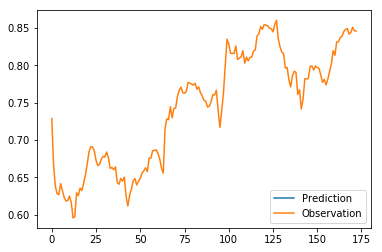

In [96]:
plt.plot(predictions2[175:348],label = 'Prediction')
plt.plot(xx[3][175:348],label = 'Observation')
# plt.plot(p2[175:348],label = 'Prediction 2')
plt.legend(loc='lower right')
plt.show()

In [ ]:
p_s8 = model.predict(xx_s8[1])
p2_s8 = model2.predict(xx2_s8[1])

In [61]:
# print (len(p))
# print (len(p2))

696
696


In [35]:
# TODO:
# 1. re-normalize
# 2. compare the loss
# 3. try with different symbols
# 4. play with build model two
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df = df[df.symbol == stock_interest]
# df.drop(['symbol'],1,inplace=True)

def denormalize(df, normalized_value): 
    df = df['adj close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

In [36]:
# get the prediction from lstm
def build_model_baseline(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [131]:
# stock_interest = 'GOOG'
# df2 = df[df.symbol == stock_interest]
# df2.drop(['symbol'],1,inplace=True)
# df2 = normalize_data(df2)
# window = 22
# X_train, y_train, X_test, y_test = load_data(df2, window)
# model = build_model_baseline([5,window,1])
# model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
# plstm = model.predict(X_test)

In [132]:
# i = 0
# plt.plot(p[i*175:(i+1)*175-1],label = 'Prediction')
# plt.plot(xx[3][i*175:(i+1)*175-1],label = 'Observation')
# plt.plot(p2[i*175:(i+1)*175-1],label = 'Prediction 2')
# plt.plot(plstm,label='LSTM')
# plt.legend(loc='best')
# plt.show()

In [38]:
stock_interest = 'AAPL'
df2 = df[df.symbol == stock_interest]
df2.drop(['symbol'],1,inplace=True)
df2 = normalize_data(df2)
window = 22
X_train, y_train, X_test, y_test = load_data(df2, window)
model = build_model_baseline([5,window,1])
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
plstm2 = model.predict(X_test)


Compilation Time :  0.019189119338989258
Train on 1408 samples, validate on 157 samples
Epoch 1/90
1408/1408 [==============================] - 6s 4ms/step - loss: 0.2386 - acc: 7.1023e-04 - val_loss: 0.3784 - val_acc: 0.0000e+00
Epoch 2/90
1408/1408 [==============================] - 5s 4ms/step - loss: 0.0967 - acc: 7.1023e-04 - val_loss: 0.0075 - val_acc: 0.0000e+00
Epoch 3/90
1408/1408 [==============================] - 5s 4ms/step - loss: 0.0738 - acc: 0.0014 - val_loss: 0.0354 - val_acc: 0.0000e+00
Epoch 4/90
1408/1408 [==============================] - 5s 4ms/step - loss: 0.0363 - acc: 7.1023e-04 - val_loss: 0.1205 - val_acc: 0.0000e+00
Epoch 5/90
1408/1408 [==============================] - 5s 4ms/step - loss: 0.0442 - acc: 7.1023e-04 - val_loss: 0.0943 - val_acc: 0.0000e+00
Epoch 6/90
1408/1408 [==============================] - 5s 4ms/step - loss: 0.0266 - acc: 7.1023e-04 - val_loss: 0.0202 - val_acc: 0.0000e+00
Epoch 7/90
1408/1408 [==============================] - 5s 4ms/s

1408/1408 [==============================] - 5s 4ms/step - loss: 0.0014 - acc: 0.0014 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 60/90
1408/1408 [==============================] - 6s 4ms/step - loss: 0.0014 - acc: 0.0014 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 61/90
1408/1408 [==============================] - 5s 4ms/step - loss: 0.0013 - acc: 0.0014 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 62/90
1408/1408 [==============================] - 5s 4ms/step - loss: 0.0013 - acc: 0.0014 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 63/90
1408/1408 [==============================] - 5s 4ms/step - loss: 0.0013 - acc: 0.0014 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 64/90
1408/1408 [==============================] - 5s 4ms/step - loss: 0.0014 - acc: 0.0014 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 65/90
1408/1408 [==============================] - 5s 4ms/step - loss: 0.0013 - acc: 0.0014 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 66/90
1408/1408 [================

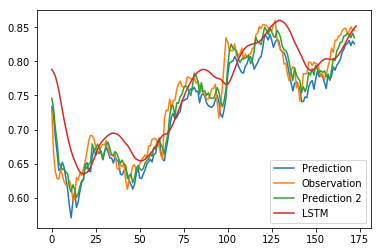

In [123]:
# print (y_test)
# print (plstm2)

i = 1
plt.plot(predictions[0][i*175:(i+1)*175-2],label = 'Prediction')
plt.plot(xx[3][i*175:(i+1)*175-2],label = 'Observation')
plt.plot(predictions2[0][i*175:(i+1)*175-2],label = 'Prediction 2')
plt.plot(plstm2,label='LSTM')
plt.legend(loc='best')
plt.show()

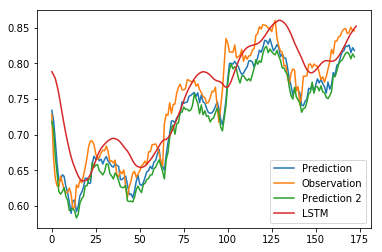

In [124]:
i = 1
plt.plot(predictions[1][i*175:(i+1)*175-2],label = 'Prediction')
plt.plot(xx[3][i*175:(i+1)*175-2],label = 'Observation')
plt.plot(predictions2[1][i*175:(i+1)*175-2],label = 'Prediction 2')
plt.plot(plstm2,label='LSTM')
plt.legend(loc='best')
plt.show()

In [100]:
print(predictions2[0].shape)

(2013, 1)


In [ ]:
# pay attention to scale

In [133]:
# TODO:
# 1. re-normalize
# 2. compare the loss
# 3. try with different symbols
# 4. play with build model two
# df = pd.read_csv("data/prices-split-adjusted.csv", index_col = 0)
# df["adj close"] = df.close # Moving close to the last column
# df.drop(['close'], 1, inplace=True) # Moving close to the last column
df3 = df[df.symbol == 'AAPL']
df3.drop(['symbol'],1,inplace=True)

def denormalize(df, normalized_value): 
    df = df['adj close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

/Users/sophiawj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [50]:
newp = denormalize(df3, p[i*175:(i+1)*175-1])
newxx = denormalize(df, xx[3][i*175:(i+1)*175-1])
newp2 = denormalize(df3, p2[i*175:(i+1)*175-1])
newplsm2 = denormalize(df3, plstm2)
obser = denormalize(df3,y_test)

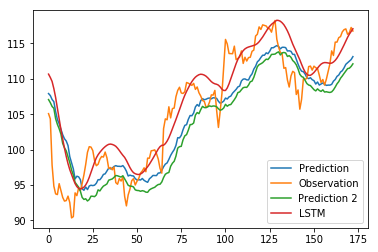

In [53]:
plt.plot(newp[0:173],label = 'Prediction')
# plt.plot(newxx,label = 'Observation')
plt.plot(obser[0:173],label = 'Observation')
plt.plot(newp2[0:173],label = 'Prediction 2')
plt.plot(newplsm2[0:173],label='LSTM')
plt.legend(loc='best')
plt.show()

In [151]:
i = 1
newp_s8 = denormalize(df3, predictions[0][i*174:(i+1)*174])
newxx = denormalize(df3, xx[3][i*174:(i+1)*174])
newp2_s8 = denormalize(df3, predictions2[0][i*174:(i+1)*174])
newplsm2 = denormalize(df3, plstm2)
# obser = denormalize(df3,y_test)

In [152]:
# print(newxx[:10])
# print(xx[3][i*175:i*175+10])
# print(predictions[0][i*175:i*175+10])

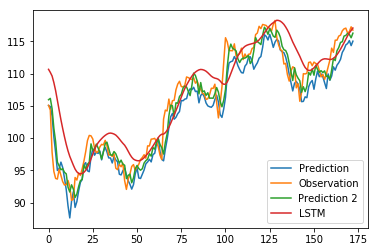

In [153]:

# obser = denormalize(df3,y_test)
plt.plot(newp_s8[0:173],label = 'Prediction')
# plt.plot(newxx,label = 'Observation')
plt.plot(newxx[0:173],label = 'Observation')
plt.plot(newp2_s8[0:173],label = 'Prediction 2')
plt.plot(newplsm2[0:173],label='LSTM')
plt.legend(loc='best')
plt.show()

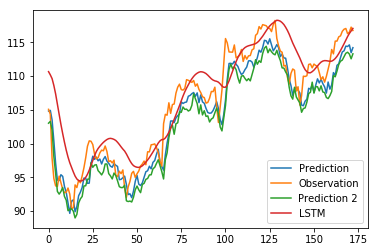

In [159]:
i = 1
newp_s12 = denormalize(df3, predictions[1][i*174:(i+1)*174])
newxx = denormalize(df3, xx[3][i*174:(i+1)*174])
newp2_s12 = denormalize(df3, predictions2[1][i*174:(i+1)*174])
newplsm2 = denormalize(df3, plstm2)
plt.plot(newp_s12[0:173],label = 'Prediction')
# plt.plot(newxx,label = 'Observation')
plt.plot(newxx[0:173],label = 'Observation')
plt.plot(newp2_s12[0:173],label = 'Prediction 2')
plt.plot(newplsm2[0:173],label='LSTM')
plt.legend(loc='best')
plt.show()

In [160]:
import sklearn.metrics
# mse_t1 = []
# mse_t2 = []
# mse_lstm = []
mse_t1.append(sklearn.metrics.mean_squared_error(newp_s12,newxx))
mse_t2.append(sklearn.metrics.mean_squared_error(newp2_s12,newxx))
mse_lstm.append(sklearn.metrics.mean_squared_error(newplsm2,newxx))
print(mse_t1)
print(mse_t2)
print(mse_lstm)

[21.573546713319548, 21.056917332150622, 7.5898694514094522, 7.5883912544282905, 7.6719897492968219]
[26.656996507570902, 25.943558505508133, 4.2925353111191624, 4.2960365426257185, 11.926873611218488]
[14.157860732567174, 19.922878874138338, 19.922878874138338, 14.157860732567174, 14.157860732567174]


In [54]:
def trend_score(actual, pred):
    trendScore = 0
    for i in range(len(actual)-1):
        if ((actual[i+1]-actual[i])*(pred[i+1]-actual[i])>0):
            trendScore=trendScore+1
    return trendScore/(len(actual)-1)

In [56]:
hitp1 = trend_score(obser, newp)
hitp2 = trend_score(obser, newp2) 
hitlstm = trend_score(obser, newplsm2) 
print(hitp1)
print(hitp2)
print(hitlstm)

0.47398843930635837
0.47398843930635837
0.5144508670520231


In [155]:
hitp1 = trend_score(newxx, newp)
hitp2 = trend_score(newxx, newp2) 
hitlstm = trend_score(newxx, newplsm2) 
print(hitp1)
print(hitp2)
print(hitlstm)

0.47398843930635837
0.47398843930635837
0.5144508670520231


In [156]:
hitp1_s8 = trend_score(newxx, newp_s8)
hitp2_s8 = trend_score(newxx, newp2_s8) 
hitlstm = trend_score(newxx, newplsm2) 
print(hitp1_s8)
print(hitp2_s8)
print(hitlstm)

0.4797687861271676
0.49710982658959535
0.5144508670520231


In [161]:
hitp1_s12 = trend_score(newxx, newp_s12)
hitp2_s12 = trend_score(newxx, newp2_s12) 
hitlstm = trend_score(newxx, newplsm2) 
print(hitp1_s12)
print(hitp2_s12)
print(hitlstm)

0.4797687861271676
0.4624277456647399
0.5144508670520231
